In [1]:
# Constants for you to change
import os

DATA_DIRECTORY = '/home/sami/py-graph'
LIVEJOURNAL_FILENAME = os.path.join(DATA_DIRECTORY, 'facebook_combined.txt.gz')
LIVEJOURNAL_URL = 'http://snap.stanford.edu/data/soc-LiveJournal1.txt.gz'

In [2]:
# Downloading the file

#import urllib.request

assert os.path.exists(DATA_DIRECTORY)

# Get your data. This file is ~250M so it will take a bit
#print('DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE')
#if not os.path.exists(LIVEJOURNAL_FILENAME):
#    urllib.request.urlretrieve(LIVEJOURNAL_URL, LIVEJOURNAL_FILENAME)

# Show a little bit of the file
print('\nFILE STATS:')
!ls -lh $LIVEJOURNAL_FILENAME
print('\nSTARTING LINES')
!zcat $LIVEJOURNAL_FILENAME | head -n 30


FILE STATS:
-rw-r--r-- 1 sami sami 214K Dec 18 18:38 /home/sami/py-graph/facebook_combined.txt.gz

STARTING LINES
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30

gzip: stdout: Broken pipe


In [3]:
# Cleaning the data

import numpy as np
import gzip

def row_generator():
    """This will generate all the edges in the graph."""
    edges = []
    with gzip.open(LIVEJOURNAL_FILENAME, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                (left_node, right_node) = line[:-1].split()
                edges.append((int(left_node), int(right_node)))
    num_edges = len(edges)
    num_nodes = max([x[0] for x in edges] + [x[1] for x in edges]) + 1
    return edges, num_edges, num_nodes

def to_undirected(edge_iterable, num_edges, num_nodes, shuffle=True):
    """Takes an iterable of edges and produces the list of edges for the undirected graph.
    
    > to_undirected([[0,1],[1,2],[2,10]], 3, 11)
    array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2, 10],
       [10,  2]])
    """
    # need int64 to do gross bithacks
    as_array = np.zeros((num_edges, 2), dtype=np.int64)
    for (i, (n_0, n_1)) in enumerate(edge_iterable):
            as_array[i,0] = n_0
            as_array[i,1] = n_1
    # The graph is directed, but we want to make it undirected,
    # which means we will duplicate some rows.

    left_nodes = as_array[:,0]
    right_nodes = as_array[:,1]
    
    if shuffle:
        the_shuffle = np.arange(num_nodes)
        np.random.shuffle(the_shuffle)
        left_nodes = the_shuffle.take(left_nodes)
        right_nodes = the_shuffle.take(right_nodes)

    
    # numpy.unique will not unique whole rows, so this little bit-hacking
    # is a quick way to get unique rows after making a flipped copy of
    # each edge.
    max_bits = int(np.ceil(np.log2(num_nodes + 1)))
    
    encoded_edges_forward = np.left_shift(left_nodes, max_bits) | right_nodes
    
    # Flip the columns and do it again:
    encoded_edges_reverse = np.left_shift(right_nodes, max_bits) | left_nodes

    unique_encoded_edges = np.unique(np.hstack((encoded_edges_forward, encoded_edges_reverse)))
    
    left_node_decoded = np.right_shift(unique_encoded_edges, max_bits)
    
    # Mask out the high order bits
    right_node_decoded = (2 ** (max_bits) - 1) & unique_encoded_edges
    
    undirected_edges = np.vstack((left_node_decoded, right_node_decoded)).T.astype(np.int32)

    # ascontiguousarray so that it's c-contiguous for cython code below
    return np.ascontiguousarray(undirected_edges)


def get_clean_data(shuffle=True):
    if shuffle:
        name = os.path.join(DATA_DIRECTORY, 'LJ-cleaned-shuffled.npy')
    else:
        name = os.path.join(DATA_DIRECTORY, 'LJ-cleaned.npy')

    if False and os.path.exists(name):
        print('Loading from file {}'.format(name))
        return np.load(name)
    else:
        print('Parsing from zip. Will write to file {}'.format(name), flush=True)
        # Lets get the edges into one big array
        edges, num_edges, num_nodes = row_generator()
        edges = to_undirected(edges, num_edges, num_nodes, shuffle=shuffle)
        print('ORIGINAL DIST: {} MIN: {} MAX: {}'.format(np.abs(edges[:,0] - edges[:,1]).mean(), edges.min(), edges.max()))
        np.save(name, edges)
        return edges, num_edges, num_nodes

In [4]:
print("Normalizing data (or loaded pre-computed)")
%time edges, num_edges, num_nodes = get_clean_data(shuffle=True)
%time unshuffled_edges, unshuffled_num_edges, unshuffled_num_nodes = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Parsing from zip. Will write to file /home/sami/py-graph/LJ-cleaned-shuffled.npy
ORIGINAL DIST: 1361.5546728018678 MIN: 0 MAX: 4038
CPU times: user 170 ms, sys: 8.28 ms, total: 179 ms
Wall time: 178 ms
Parsing from zip. Will write to file /home/sami/py-graph/LJ-cleaned.npy
ORIGINAL DIST: 289.4173561212231 MIN: 0 MAX: 4038
CPU times: user 150 ms, sys: 3.88 ms, total: 154 ms
Wall time: 154 ms

EDGES SHAPE: (176468, 2)


In [5]:
def score(assignment, edges):
    """Compute the score given an assignment of vertices.
    
    N nodes are assigned to clusters 0 to K-1.
    
    assignment: Vector where N[i] is the cluster node i is assigned to.
    edges: The edges in the graph, assumed to have one in each direction
    
    Returns: (total wasted bin space, ratio of edges cut)
    """
    balance = np.bincount(assignment) / len(assignment)
    waste = (np.max(balance) - balance).sum()
    
    left_edge_assignment = assignment.take(edges[:,0])
    right_edge_assignment = assignment.take(edges[:,1])
    mismatch = (left_edge_assignment != right_edge_assignment).sum()
    cut_ratio = mismatch / len(edges)
    return (waste, cut_ratio)

In [6]:
%load_ext Cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left

        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [8]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Ratio of edges crossing partitions')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [9]:
def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()
    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, num_nodes, num_partitions, assignments)
        (waste, edge_score) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}'.format(i, waste, edge_score))
    draw_figures(waste_values, edge_score_values, num_partitions)


4 PARTITIONS
ROUND	WASTE	SCORE
0	0.001	0.426
1	0.001	0.172
2	0.001	0.117
3	0.001	0.141
4	0.001	0.146
5	0.001	0.118
6	0.001	0.121
7	0.001	0.113
8	0.001	0.124
9	0.001	0.110
10	0.001	0.122
11	0.001	0.110
12	0.001	0.122
13	0.001	0.110
14	0.001	0.122
CPU times: user 146 ms, sys: 4.16 ms, total: 150 ms
Wall time: 149 ms


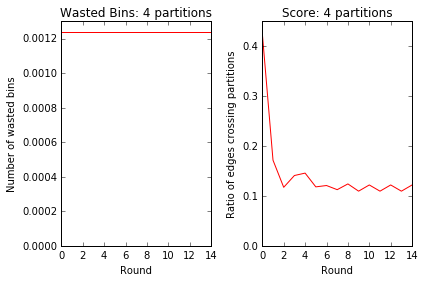

In [10]:
# Use the greedy method to break into 4 partitions
%time run_restreaming_greedy(edges, num_nodes, num_partitions=4, num_iterations=15)


40 PARTITIONS
ROUND	WASTE	SCORE
0	0.367	0.720
1	0.367	0.591
2	0.367	0.563
3	0.367	0.534
4	0.367	0.514
5	0.367	0.506
6	0.367	0.510
7	0.367	0.509
8	0.367	0.508
9	0.367	0.503
10	0.367	0.504
11	0.367	0.509
12	0.367	0.501
13	0.367	0.501
14	0.367	0.498
CPU times: user 191 ms, sys: 3.76 ms, total: 195 ms
Wall time: 194 ms


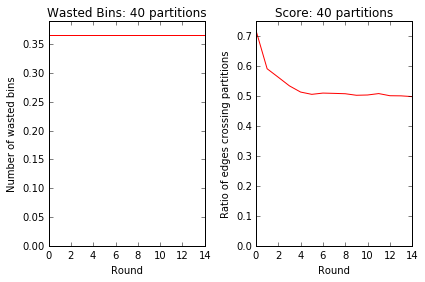

In [11]:
# Use the greedy method to break into 20 partitions
%time run_restreaming_greedy(edges, num_nodes, num_partitions=40, num_iterations=15)

In [12]:
%%cython
import numpy as np

cdef int UNMAPPED = -1

def fennel(int[:,::] edges,
           int num_nodes,
           int num_partitions,
           int[::] partition,
           float alpha):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    partition: A previous partition of the nodes. Set to -1's if a node has not been assigned.
    """
    
    cdef int[::] partition_sizes = None
    # The output partition
    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
        partition_sizes = np.zeros(num_partitions, dtype=np.int32)
    else:
        partition_sizes = np.bincount(partition).astype(np.int32)
    
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    cdef float partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef float max_val = 0
    cdef float val = 0
    cdef int len_edges = len(edges)
    cdef int previous_assignment = 0

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # New left node, so we have to assign last left

            # Remember placement of last_left in the previous assignment
            previous_assignment = partition[last_left]
            
            max_arg = 0
            max_val = partition_votes[0] - alpha * partition_sizes[0]
            if previous_assignment == 0:
                # We remove the node from its current partition before
                # deciding to re-add it, so subtract alpha to give
                # result of 1 lower partition size.
                max_val += alpha

            for arg in range(1, num_partitions):
                val = partition_votes[arg] - alpha * partition_sizes[arg]
                if previous_assignment == arg:
                    # See comment above
                    val += alpha
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_arg != previous_assignment:
                partition[last_left] = max_arg
                partition_sizes[max_arg] += 1
                if previous_assignment != UNMAPPED:
                    partition_sizes[previous_assignment] -= 1

            partition_votes[:] = 0
            last_left = left

        if partition[right] != -1:
            partition_votes[partition[right]] += 1
    
    # TODO: finish off this fencepost....
    partition[left] = 0
    
    return np.asarray(partition)

In [13]:
def run_fennel_restreaming(edges, num_nodes, num_partitions, num_iterations):
    print('{} PARTITIONS'.format(num_partitions))
    assignments = None
    # We will explore this parameter in a future post. This is sub-optimal
    alphas = np.linspace(1.251608191745264e-07, 7.588951557309824e-05, num_iterations)
    waste_scores, edge_score_values = [], []
    print('ROUND\tALPHA\tWASTE\tSCORE')
    for i in range(num_iterations):
        alpha = alphas[i]
        assignments = fennel(edges, num_nodes, num_partitions, assignments, alpha)
        (waste, edge_score) = score(assignments, edges)
        print('{}\t{:.1e}\t{:0.3f}\t{:0.3f}'.format(i, alpha, waste, edge_score))
        waste_scores.append(waste)
        edge_score_values.append(edge_score)
    draw_figures(waste_scores, edge_score_values, num_partitions)

4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.054	0.099
1	5.5e-06	0.046	0.048
2	1.1e-05	0.036	0.045
3	1.6e-05	0.047	0.044
4	2.2e-05	0.053	0.042
5	2.7e-05	0.053	0.042
6	3.3e-05	0.053	0.042
7	3.8e-05	0.053	0.042
8	4.3e-05	0.053	0.042
9	4.9e-05	0.053	0.042
10	5.4e-05	0.053	0.042
11	6.0e-05	0.053	0.042
12	6.5e-05	0.053	0.042
13	7.0e-05	0.053	0.042
14	7.6e-05	0.053	0.042
CPU times: user 201 ms, sys: 72 µs, total: 201 ms
Wall time: 199 ms


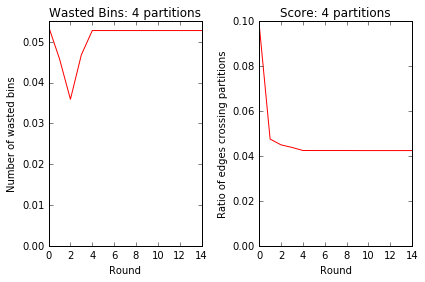

In [14]:
%time run_fennel_restreaming(edges, num_nodes, 4, 15)

20 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.956	0.171
1	5.5e-06	1.213	0.103
2	1.1e-05	1.208	0.093
3	1.6e-05	1.204	0.087
4	2.2e-05	1.342	0.083
5	2.7e-05	1.407	0.080
6	3.3e-05	1.407	0.080
7	3.8e-05	1.407	0.080
8	4.3e-05	1.407	0.080
9	4.9e-05	1.407	0.080
10	5.4e-05	1.407	0.080
11	6.0e-05	1.407	0.080
12	6.5e-05	1.407	0.080
13	7.0e-05	1.407	0.080
14	7.6e-05	1.407	0.080
CPU times: user 186 ms, sys: 7.74 ms, total: 194 ms
Wall time: 193 ms


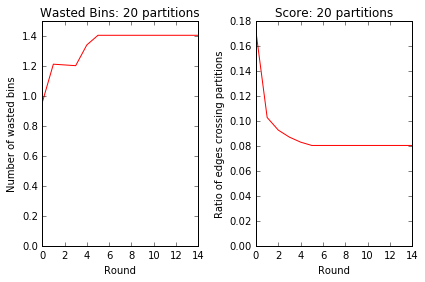

In [15]:
%time run_fennel_restreaming(edges, num_nodes, 20, 15)